
# https://www.bnlearn.com/research/scirep17/


In [1]:
load("prepd-ortho.rda")
str(ortho)

'data.frame':	143 obs. of  17 variables:
 $ ID       : Factor w/ 143 levels "P001","P002",..: 1 2 4 5 6 7 9 10 11 13 ...
 $ Treatment: Factor w/ 3 levels "NT","TB","TG": 1 1 1 1 1 1 1 1 3 1 ...
 $ Growth   : Factor w/ 2 levels "Bad","Good": 1 2 1 1 1 2 2 2 1 1 ...
 $ ANB      : num  -5.2 -1.7 -3.1 -1.3 0.4 1.5 -0.1 0.5 0.2 0.2 ...
 $ IMPA     : num  75.9 77.2 89.8 98.7 90.5 96.9 85.9 92 91.7 82.2 ...
 $ PPPM     : num  30.2 27 19.8 21.5 26.5 25.2 21.2 19.5 31.1 22.7 ...
 $ CoA      : num  83.4 91.3 78.6 96.4 83.3 88 85 77.1 88.8 77.5 ...
 $ GoPg     : num  77.9 84.1 67.3 75.6 74.7 72.8 75.2 65.2 76.2 67.8 ...
 $ CoGo     : num  50.1 59.2 50.4 65.7 51.3 58 54.9 44.8 53.3 44.5 ...
 $ ANB2     : num  -8.4 -2.3 -4.7 -2.4 -0.7 0.9 -1.3 0.4 0.8 -2.8 ...
 $ IMPA2    : num  71.7 81 83.8 86.6 83.8 95.8 87.7 93.6 92.3 82.6 ...
 $ PPPM2    : num  29.1 26.5 16.7 19.4 26.5 24.3 19.4 17.2 30.2 20.1 ...
 $ CoA2     : num  84.4 93.9 82.9 110.5 91 ...
 $ GoPg2    : num  81.9 84 71.5 96.3 83.5 71.8 76.9

In [2]:
load("prepd-bathia.rda")

In [3]:
diff = data.frame(
dANB = ortho$ANB2 - ortho$ANB,
dPPPM = ortho$PPPM2 - ortho$PPPM,
dIMPA = ortho$IMPA2 - ortho$IMPA,
dCoA = ortho$CoA2 - ortho$CoA,
dGoPg = ortho$GoPg2 - ortho$GoPg,
dCoGo = ortho$CoGo2 - ortho$CoGo,
dT = ortho$T2 - ortho$T1,
Growth = as.numeric(ortho$Growth) - 1,
Treatment = as.numeric(ortho$Treatment != "NT")
)

In [4]:
table(ortho[, c("Treatment", "Growth")])

         Growth
Treatment Bad Good
       NT  51   26
       TB  10    3
       TG  24   29

In [5]:
table(diff[, c("Treatment", "Growth")])

         Growth
Treatment  0  1
        0 51 26
        1 34 32

In [7]:
install.packages('gplots')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘gtools’, ‘caTools’




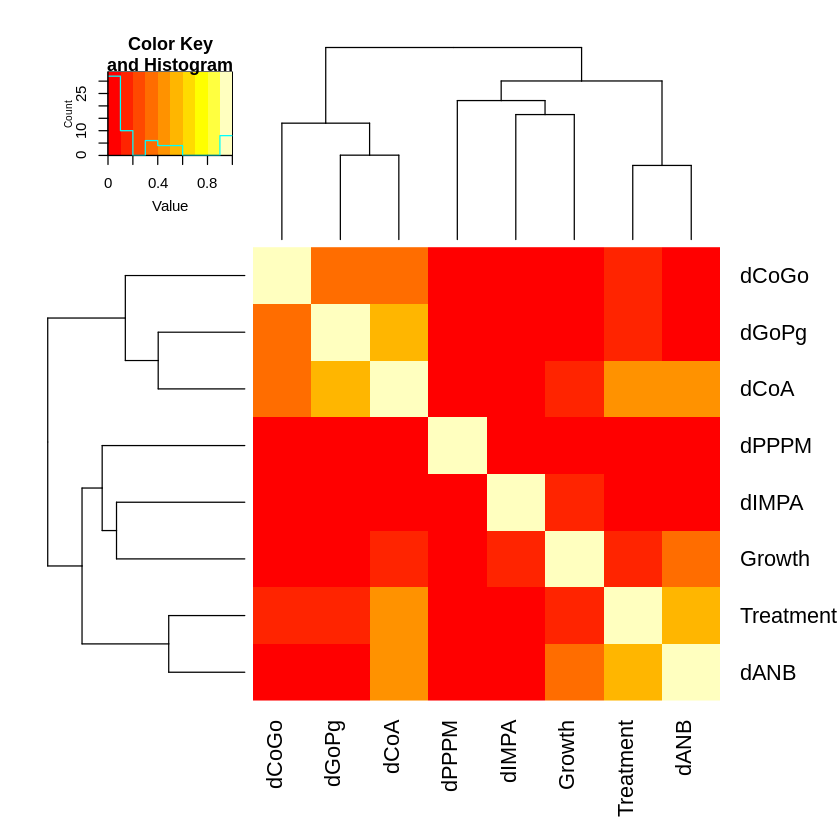

In [11]:
library(gplots)
diff.delta = sapply(diff[, 1:6], function(x) x / diff$dT)
rho = cor(data.frame(diff.delta, Growth = diff$Growth, Treatment = diff$Treatment))
palette.breaks = seq(0, 1, 0.1)
par(oma=c(2,2,2,1))
heatmap.2(rho, scale = "none", trace = "none", revC = TRUE, breaks = palette.breaks)

In [13]:
install.packages('bnlearn')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [19]:
if (!require("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

BiocManager::install("Rgraphviz")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.19 (BiocManager 1.30.23), R 4.4.1 (2024-06-14)

Installing package(s) 'BiocVersion', 'Rgraphviz'

also installing the dependencies ‘BiocGenerics’, ‘graph’




Loading required namespace: Rgraphviz



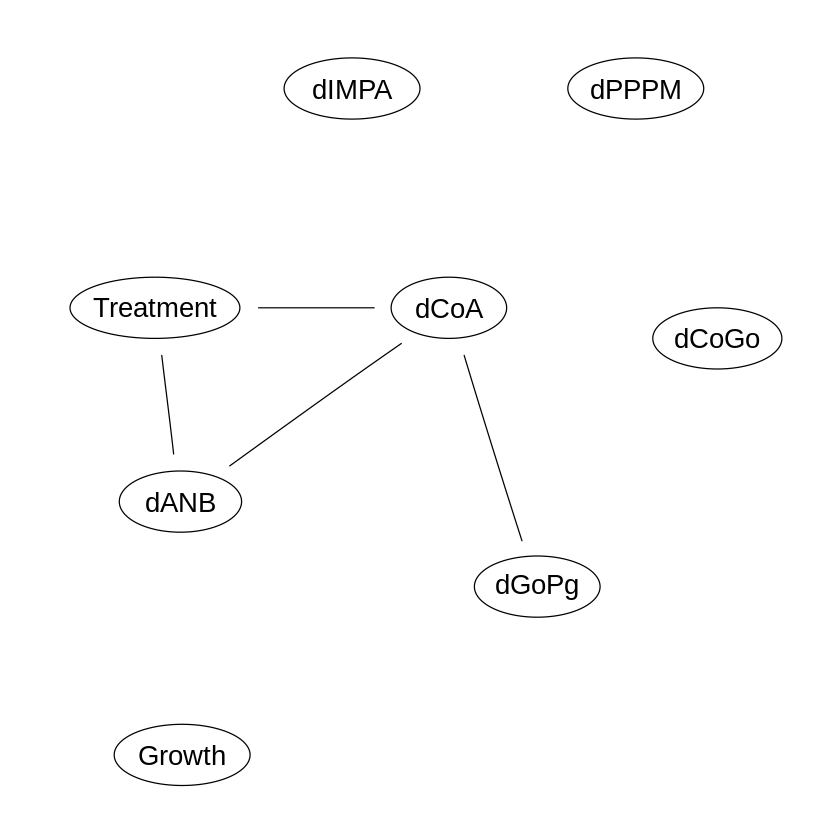

In [20]:
library(bnlearn)

ug = empty.graph(colnames(rho))
amat(ug) = (rho > 0.4) + 0L - diag(1L, nrow(rho))
graphviz.plot(ug, layout = "fdp", shape = "ellipse")

In [21]:
bl = tiers2blacklist(list("dT", "Treatment", "Growth",
       c("dANB", "dPPPM", "dIMPA", "dCoA", "dGoPg", "dCoGo")))
bl = rbind(bl, c("dT", "Treatment"), c("Treatment", "dT"))
wl = matrix(c("dANB", "dIMPA",
              "dPPPM", "dIMPA",
              "dT", "Growth"),
        ncol = 2, byrow = TRUE, dimnames = list(NULL, c("from", "to")))

In [23]:
str.raw = boot.strength(diff, R = 200, algorithm = "hc",
            algorithm.args = list(whitelist = wl, blacklist = bl))
attr(str.raw, "threshold")
avg.raw.full = averaged.network(str.raw)

[1] 0.515

Warning message in averaged.network.backend(strength = strength, threshold = threshold):
“arc dCoA -> dCoGo would introduce cycles in the graph, ignoring.”


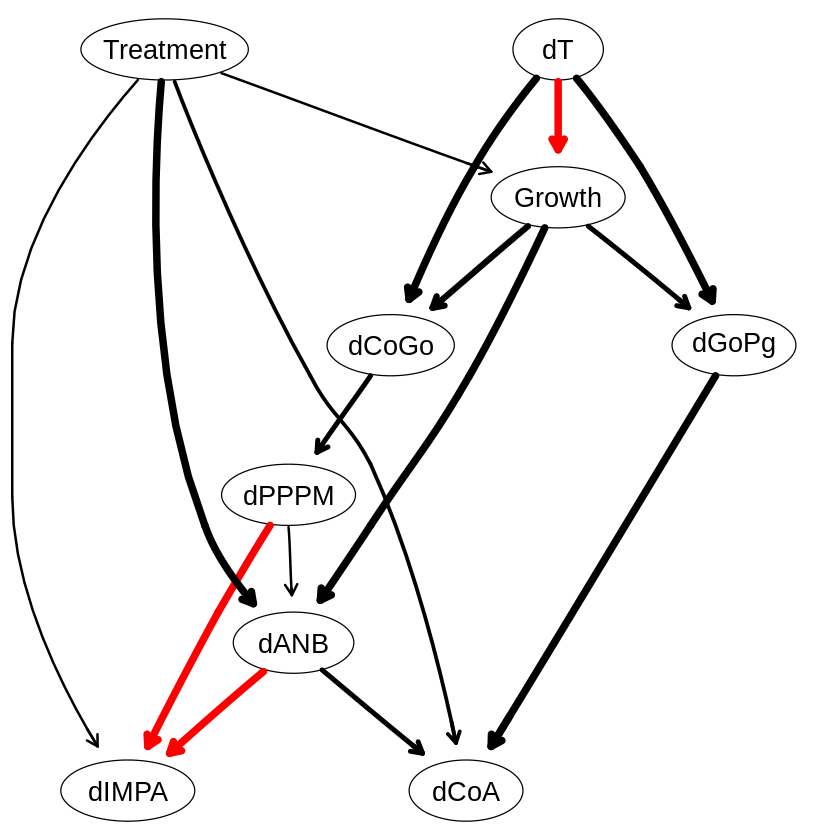

In [24]:
strength.plot(avg.raw.full, str.raw, shape = "ellipse", highlight = list(arcs = wl))

In [25]:
avg.raw.full$learning$whitelist = wl
avg.raw.full$learning$blacklist = bl
nrow(undirected.arcs(cpdag(avg.raw.full, wlbl = TRUE)))

[1] 0

In [26]:
nrow(str.raw[with(str.raw, strength > 0.50 & direction > 0.50), ])

[1] 18

In [27]:
nrow(str.raw[with(str.raw, strength > 0.85 & direction > 0.50), ])

[1] 12

In [28]:
min(str.raw[with(str.raw, strength > 0.50 & direction > 0.50), "direction"])

[1] 0.565

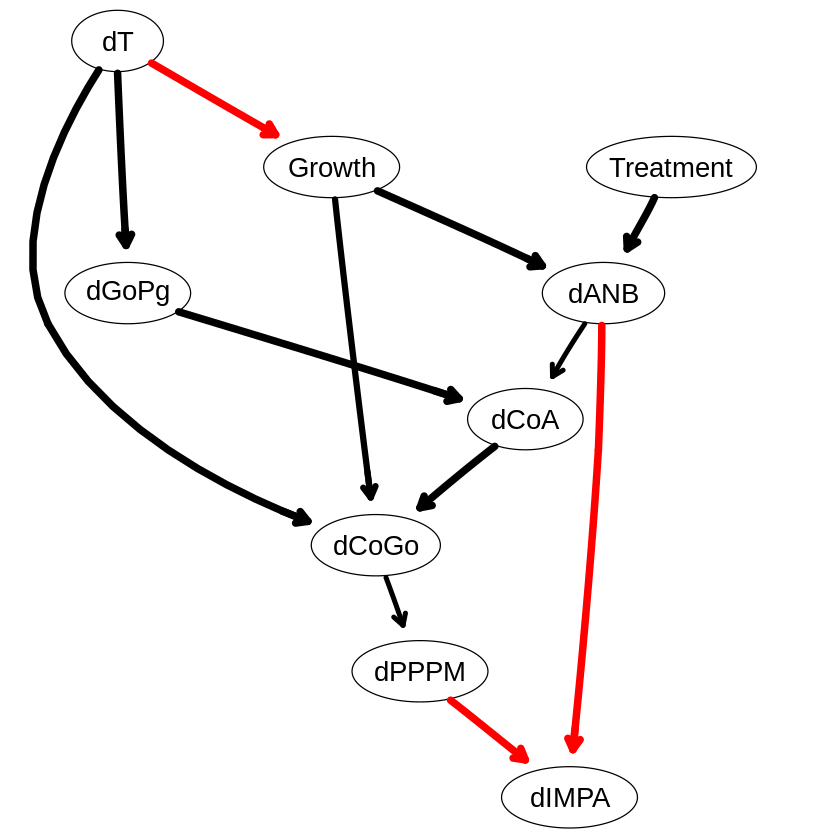

In [29]:
avg.raw.simpler = averaged.network(str.raw, threshold = 0.85)
strength.plot(avg.raw.simpler, str.raw, shape = "ellipse", highlight = list(arcs = wl))

In [30]:
xval = bn.cv(diff, bn = "hc",
  algorithm.args = list(blacklist = bl, whitelist = wl), loss = "cor-lw",
  loss.args = list(target = "Growth", n = 200), runs = 10)

err = numeric(10)

for (i in 1:10) {

  tt = table(unlist(sapply(xval[[i]], '[[', "observed")),
             unlist(sapply(xval[[i]], '[[', "predicted")) > 0.50)

  err[i] = (sum(tt) - sum(diag(tt))) / sum(tt)

}#FOR

summary(err)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.2587  0.2675  0.2727  0.2734  0.2797  0.2867 

In [31]:
predcor =
  structure(numeric(6),
    names = c("dCoGo", "dGoPg", "dIMPA", "dCoA", "dPPPM", "dANB"))

for (var in names(predcor)) {

  xval = bn.cv(diff, bn = "hc",
    algorithm.args = list(blacklist = bl, whitelist = wl), loss = "cor-lw",
    loss.args = list(target = var, n = 200), runs = 10)

    predcor[var] = mean(sapply(xval, function(x) attr(x, "mean")))

}#FOR

round(predcor, digits = 3)

mean(predcor)

dCoGo dGoPg dIMPA  dCoA dPPPM  dANB 
0.848 0.904 0.204 0.925 0.400 0.654

[1] 0.6558982

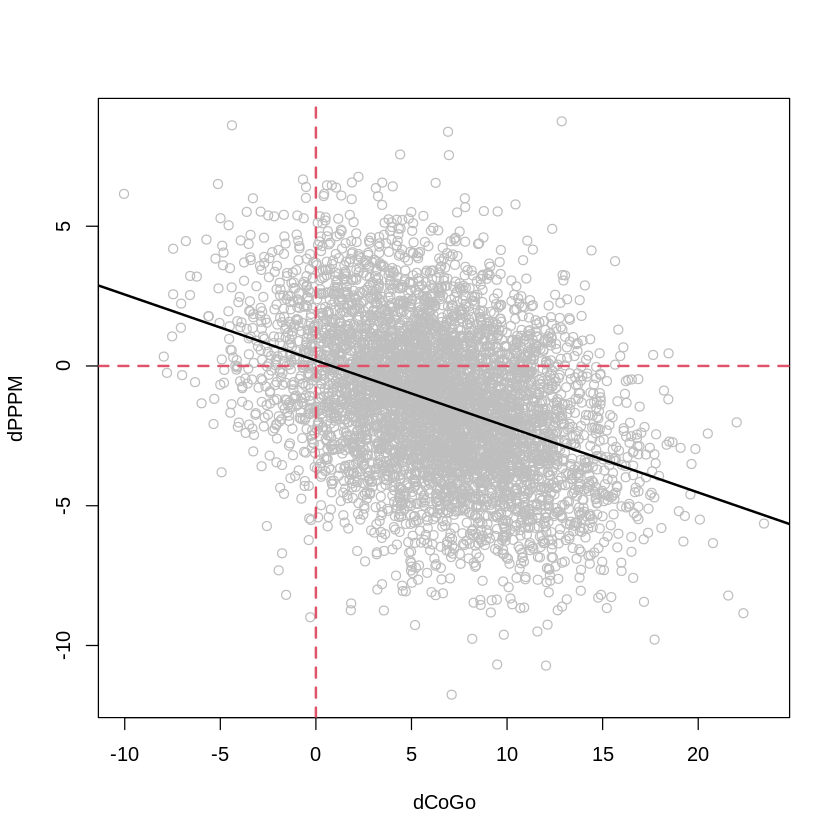

In [32]:
fitted.raw.simpler = bn.fit(avg.raw.simpler, diff)
sim = cpdist(fitted.raw.simpler, nodes = c("dCoGo", "dPPPM"), n = 10^4,
        evidence = (Treatment < 0.5))
plot(sim, col = "grey")
abline(v = 0, col = 2, lty = 2, lwd = 2)
abline(h = 0, col = 2, lty = 2, lwd = 2)
abline(coef(lm(dPPPM ~ dCoGo, data = sim)), lwd = 2)

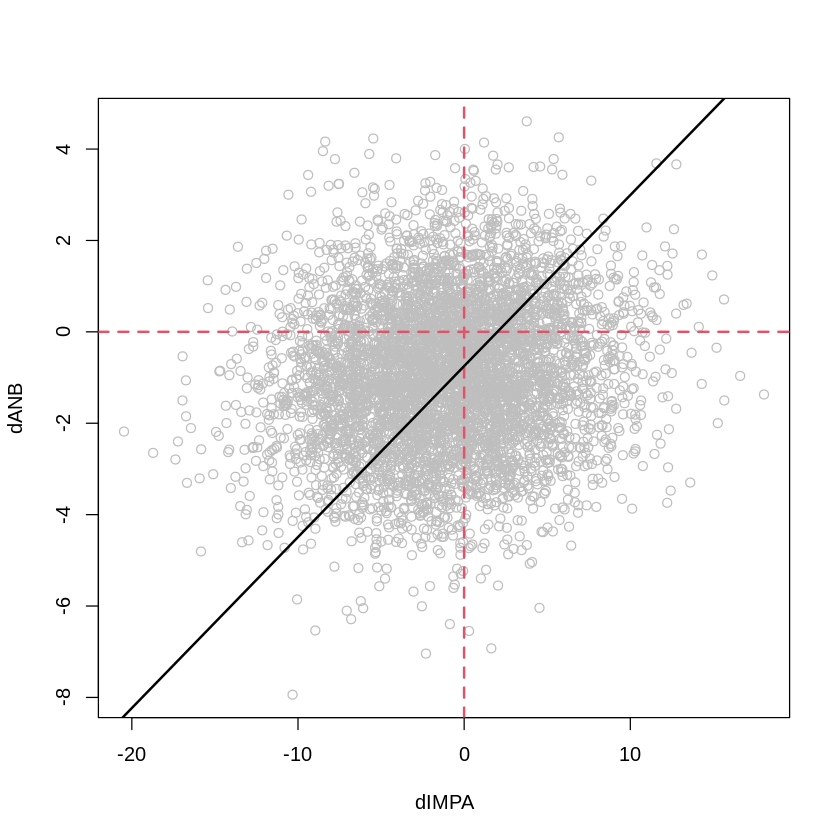

In [33]:
sim = cpdist(fitted.raw.simpler, nodes = c("dIMPA", "dANB"), n = 10^4,
        evidence = (Treatment < 0.5))
plot(sim, col = "grey")
abline(v = 0, col = 2, lty = 2, lwd = 2)
abline(h = 0, col = 2, lty = 2, lwd = 2)
abline(coef(lm(dIMPA ~ dANB, data = sim)), lwd = 2)

In [34]:
sim = cpdist(fitted.raw.simpler, nodes = c("Treatment", "Growth"), n = 5 * 10^4,
        evidence = abs(dANB) < 0.1)
tab = table(TREATMENT = sim$Treatment < 0.5, GOOD.GROWTH = sim$Growth > 0.5)
round(prop.table(tab, margin = 1), 2)

         GOOD.GROWTH
TREATMENT FALSE TRUE
    FALSE  0.62 0.38
    TRUE   0.51 0.49

In [35]:
sim.GoPg = cpdist(fitted.raw.simpler, nodes = c("Treatment", "dANB", "dGoPg"),
        evidence = abs(dGoPg) < 0.1)

In [36]:
sim.GoPg$Treatment = c("UNTREATED", "TREATED")[as.numeric(sim.GoPg$Treatment > 0.5) + 1L]
mean(sim.GoPg[sim.GoPg$Treatment == "UNTREATED", "dANB"])

[1] -0.9784359

In [37]:
mean(sim.GoPg[sim.GoPg$Treatment == "TREATED", "dANB"])

[1] 0.9360756

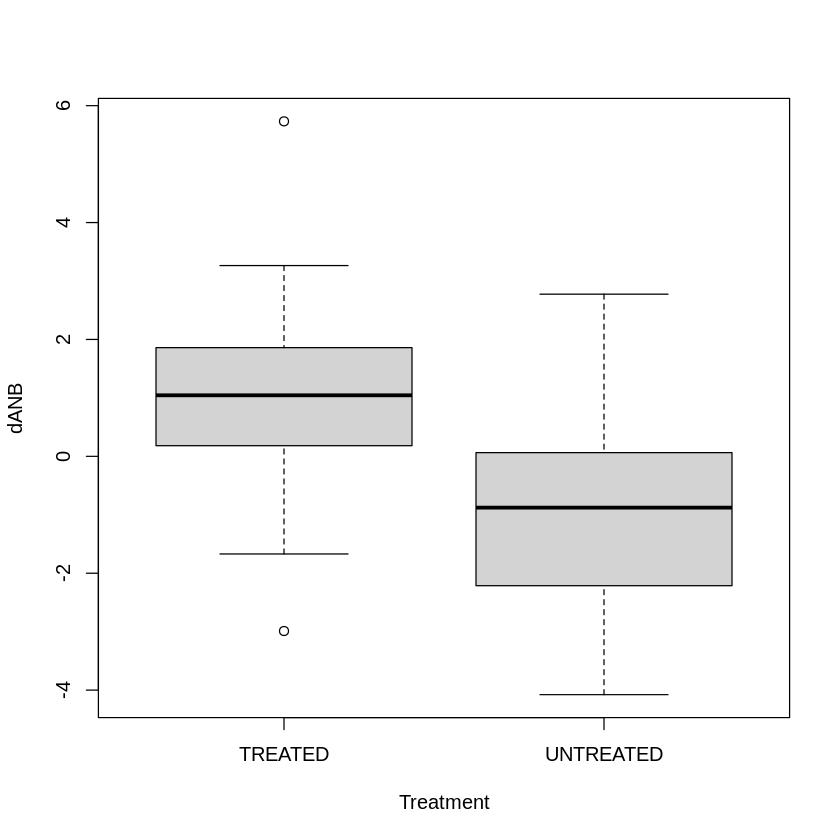

In [38]:
boxplot(dANB ~ Treatment, data = sim.GoPg)